In [1]:
import pandas as pd
import numpy as np
import math
import sys
import os
import matplotlib.pyplot as plt
from IPython.display import display

from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks

In [2]:
from itertools import combinations

measures = ['f1', 'ratio_selection_rate', 'ratio_recall', 'ratio_odds']

def multicriteria(measurement_values):
    pairs = list(combinations(measurement_values, 2))
    area = 0
    for a, b in pairs:
        area += (a*b*math.sin((2*math.pi)/3)/2)    
    return area

def multicriteria_validation(validation):
    matrix = validation[measures].to_numpy()
    validation['multicriteria'] = [multicriteria(row) for row in matrix]
    return validation

In [3]:
results_valid = pd.DataFrame(columns = ['Dataset', 'Config', '(none)', '(class)', '(group)', '(group, class)'])
results_test = pd.DataFrame(columns = ['Dataset', 'Config', '(none)', '(class)', '(group)', '(group, class)'])

count = 0

for name in ['adult', 'alcohol', 'arrhythmia', 'bank', 'compasmen', 'compaswomen', 
             'contraceptive', 'german', 'heart', 'lsd', 'nicotine', 'titanic']:
    for config in ['ad', 'dt', 'mlp', 'svm', 'rf', 'xgb']:
        ''' abre os resultados '''
        if os.path.exists('../Experiments/' + name + '_' + config + '_validation.csv'):
            validation = pd.read_csv('../Experiments/' + name + '_' + config + '_validation.csv', sep=';', index_col=0) 
            test = pd.read_csv('../Experiments/' + name + '_' + config + '_test.csv', sep=';', index_col=0)
            ''' Calcula ratio odds '''
            validation['ratio_odds'] = (validation['ratio_fpr'] + validation['ratio_recall'])/2
            test['ratio_odds'] = (test['ratio_fpr'] + test['ratio_recall'])/2
            ''' Calcula multicriterio '''
            validation = multicriteria_validation(validation)
            test = multicriteria_validation(test)

            values_valid = []
            values_valid.append(name)
            values_valid.append(config)

            values_test = []
            values_test.append(name)
            values_test.append(config)

            for by in ['none', 'target', 'group', 'group_target']:

                aux_validation = validation.loc[validation['stratified'] == by].copy()
                aux_validation = aux_validation.sort_values(by=['clf_name'])
                aux_validation = aux_validation.reset_index()

                aux_test = test.loc[test['stratified'] == by].copy()
                aux_test = aux_test.sort_values(by=['clf_name'])
                aux_test = aux_test.reset_index()

                idx = aux_validation['multicriteria'].idxmax()
                values_valid.append(aux_validation.loc[idx, 'multicriteria'])
                values_test.append(aux_test.loc[idx, 'multicriteria'])
                #print(name, config, by, aux_test.loc[idx, 'clf_name'], aux_test.loc[idx, 'clf_params'])

            results_valid.loc[count] = values_valid
            results_test.loc[count] = values_test
            count += 1

In [4]:
results_test.groupby(by=['Dataset']).mean()

/tmp/ipykernel_24684/2435707002.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_test.groupby(by=['Dataset']).mean()


,(none),(class),(group),"(group, class)"
Dataset,,,,
adult,0.927137,0.915405,0.931327,0.933399
alcohol,2.556067,2.585251,2.582544,2.585251
arrhythmia,1.314054,1.357171,1.208754,1.377748
bank,1.068700,1.086006,1.096134,1.058488
compasmen,1.230896,1.251311,1.274013,1.278548
compaswomen,1.216101,1.180039,1.189163,1.218689
contraceptive,1.816751,1.866727,1.868475,1.931385
german,2.114071,2.136196,2.142466,2.158608
heart,1.255767,1.354997,1.354231,1.424901


In [5]:
df = results_test[['(none)', '(class)', '(group)', '(group, class)']]
algorithms_names = df.columns
results_array = df.values

# calcula os ranks
ranks_test = np.array([rankdata(-p) for p in results_array])

# calcula a média dos ranks
average_ranks = np.mean(ranks_test, axis=0)
print('\n'.join('({}) Rank average: {}'.format(a, r) for a, r in zip(algorithms_names, average_ranks)))

((none)) Rank average: 2.7777777777777777
((class)) Rank average: 2.576388888888889
((group)) Rank average: 2.5833333333333335
((group, class)) Rank average: 2.0625


0.49301808519345824


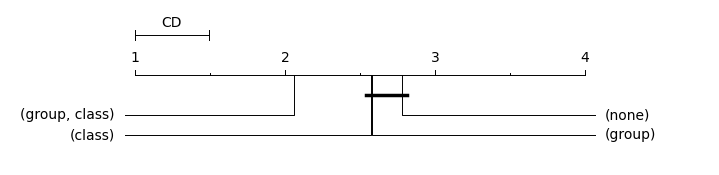

In [6]:
# This method computes the critical difference for Nemenyi test
cd = compute_CD(average_ranks, n=len(df), alpha='0.1', test='nemenyi')
print(cd)
# This method generates the plot.
graph_ranks(average_ranks, names=algorithms_names, cd=cd, width=7, textspace=1.25, reverse=False, 
            filename='cd.pdf')